In [2]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3 import *
from shutil import copyfile
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import plotting_params

In [3]:
def repeat(arr, count):
    z_sig = []
    for i in range(count):
        z_sig.extend(arr)
    return z_sig


In [4]:
def mock_injection_signal(alpha_scale,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF"):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    signal_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    #plt.plot(1*signal_sim[1])
    #plt.ylabel("Force [N]")
    #plt.xlabel("time[s]")
    #plt.show()
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    TF_phases = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]    
    if(phase_shift=="TF"):TF_phase_shift = TF_phases
    elif(phase_shift=="Flip"):TF_phase_shift = [-1*element for element in TF_phases] # this flips
    elif(phase_shift=="Random_TF"):TF_phase_shift = [1*np.random.normal(element,element/20) for element in TF_phases]
    elif(phase_shift=="Random"):TF_phase_shift =  np.random.uniform(-np.pi,np.pi,len(TF_phases))
    else:TF_phase_shift = len(TF_phases)*[0]
    print(TF_phase_shift)
    harmonics = np.arange(3,len(TF_phases)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    amplitude_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]

    fft_sim = np.fft.rfft(signal_sim[1]) 
    new_fft_sim = fft_sim.copy()
    new_fft_shift_only = fft_sim.copy()
    #new_fft_sim[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim[0]) # not necessary?
    for harmonic in harmonics:
        new_fft_shift_only[harmonic] = np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))
        new_fft_sim[harmonic] = 1/amplitude_scale[harmonic//3-1] * np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))

    signal_sim_shift=np.fft.irfft(new_fft_shift_only) 
    signal_sim_shift_scale =np.fft.irfft(new_fft_sim) 
    
    
    # extend to 10s
    z_sig = repeat(signal_sim_shift_scale,10)
    # scale to desired alpha
    z_sig_10 = np.multiply(z_sig,alpha_scale)
    
    #plt.plot(z_sig_10)
    #plt.xlim(0,5000)
    #plt.xlabel("time [s]")
    #plt.ylabel("intensity [bits]")
    #plt.show()
    return z_sig_10,TF_phase_shift,amplitude_scale

In [5]:
def mock_injection_bkg(alpha_scale_bkg,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    background_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]
    harmonics = np.arange(3,len(TF_phases_bkg)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    
    #alpha_scale_bkg = [1/1]*len(TF_phases)#/1e10
    TF_amp_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]
    amplitude_scale = np.multiply(TF_amp_scale,alpha_scale_bkg)
    fft_sim_bkg = np.fft.rfft(background_sim[1]) 
        
    new_fft_sim_bkg = fft_sim_bkg.copy()
    #new_fft_sim_bkg[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim_bkg[0]) # not necessary?
    #print(np.abs(fft_sim_bkg[0]),1/np.mean(amplitude_scale),np.abs(new_fft_sim_bkg[0]))

    for harmonic in harmonics:
        new_fft_sim_bkg[harmonic] = 1/amplitude_scale[harmonic//3-1]*(np.abs(fft_sim_bkg[harmonic])) *np.exp(1j*(np.angle(fft_sim_bkg[harmonic])+TF_phases_bkg[harmonic//3-1]))

    signal_sim_bkg =np.fft.irfft(new_fft_sim_bkg) 
    
    
    # extend to 10s
    z_bkg = repeat(signal_sim_bkg,10)
    # scale to desired alpha - not used anymore
    z_bkg_10 = np.multiply(z_bkg,1)
    ##plt.plot(z_bkg_10)
    #plt.xlim(0,5000)
    #plt.xlabel("time [s]")
    #plt.ylabel("intensity [bits]")
    #plt.show()    
    return z_bkg_10,TF_phases_bkg,amplitude_scale,alpha_scale_bkg

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force


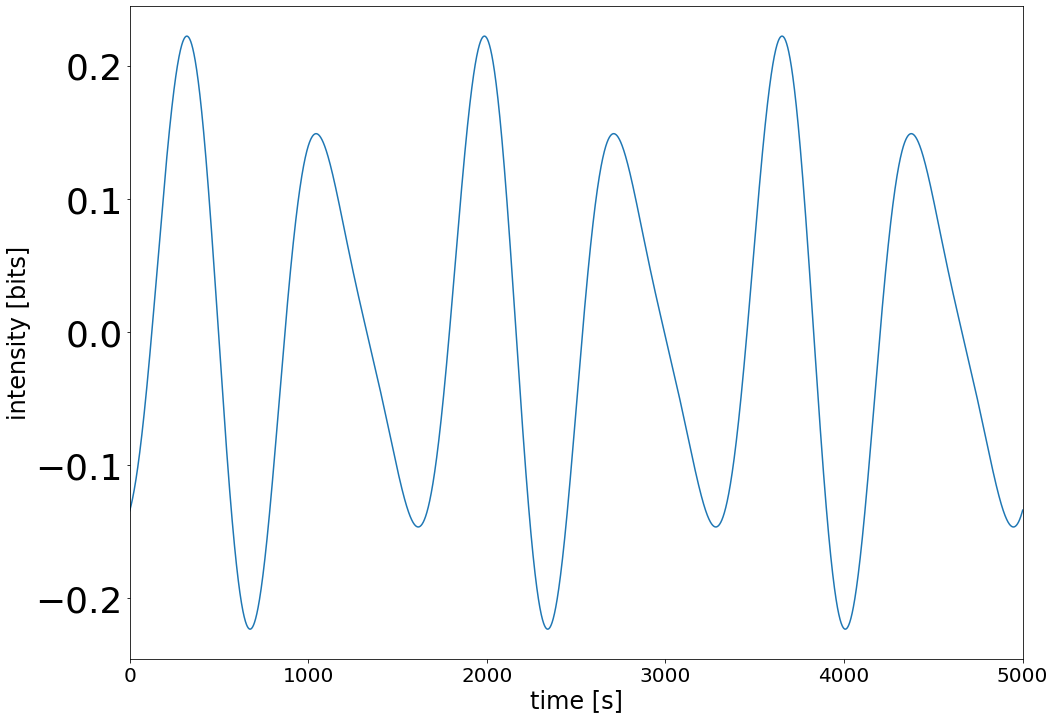

In [6]:
ab = [1/1e1]*1+[1/1e8]+[1/1e1]*11
a,_,_,_ = mock_injection_bkg(ab,10)
ab2 = [1/1e1]*2+[1/1e8]+[1/1e1]*10
a2,_,_,_ = mock_injection_bkg(ab2,10)
plt.plot(a-a2)
plt.xlim(0,5000)
plt.xlabel("time [s]")
plt.ylabel("intensity [bits]")
plt.show()  

In [7]:
def file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction,run_no,max_file=1000):
    i=0
    out_dirs=  out_dir+"/%d/" %run_no
    try: os.makedirs(out_dirs)
    except: print("Did not create %s. It may exist or you do not have perimissions." %out_dir)    

    for file_path in in_file_paths:
        #print(file_path)
        i+=1
        if(i<(max_file+1)):
            #if (i % 10==0):print("%f percent" %(i/max_file*100))
            with h5py.File(file_path, 'r') as f_in:
                quad_data_in = np.array(f_in['quad_data'])
                data_in = quad_data_in.reshape(-1,12).T[9]
                #plt.plot(np.array(data_in))
                random_uni =np.random.uniform(-0.5,0.5,len(data_in)) # make a list of random numbers between -0.5 and 0.5
                new_data_uni = data_in + random_uni# add them                 
                if(direction=="push"): z_sn = np.subtract(np.array(new_data_uni),np.array(final_signal))
                elif(direction=="pull"): z_sn = np.add(np.array(new_data_uni),np.array(final_signal))
                else: print("Force has to go either way")
                z_sn_round = [round(element) for element in z_sn] # round to half even
                quad_data_in.reshape(-1,12).T[9] = z_sn_round
                f_in.close()
                #plt.plot(np.array(z_sn),color="black")
            out_path = out_dirs + "Noise_batch_%d.h5" %(i-1)
            copyfile(src=file_path, dst=out_path)
            with h5py.File(out_path, 'r+') as f_out:
                del f_out['quad_data']
                f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
                f_out.close()
    return print("Done")

In [8]:
def metafile_creator_bkg(x):
    f = open(out_dir+"run_%d.txt" %x, "w")
    f.write("Run number: %d\n alpha value bkg push: %s \n alpha value bkg pull: %s \n TF_phases_bkg: %s " %(run_no[x],alpha_bkg_push,alpha_bkg_pull,phases_bkg))
    f.close()
    return

In [9]:
def metafile_creator(x):
    f = open(out_dir+"run_%d.txt" %x, "w")
    f.write("Run number: %d\n alpha value: %f \n lambda value: %f \n direction: %s \n %s %s \n Amplitude scale %s" %(run_no[x],alpha_scale_in[x],lambda_val_in[x],direction_in[x],phase_shift_in[x],str(TF_phase_shift),str(amplitude_scale)))
    f.close()
    return

In [24]:
in_dir = r"/data/new_trap_processed/mockfiles/20200320/raw/noise/"
out_dir = r"/data/new_trap_processed/mockfiles/20200320/output/noise/testforalex2/"

in_file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    in_file_paths.append(file_path)



In [20]:
no=2
# make lists
alpha_scale_in = [np.random.randint(1,2)*1e9 for x in range(no)]
lambda_val_in = [10]*no
direction_in = no*["pull"]
phase_shift_in = no*["TF"]

In [16]:
def create_alpha_scale_bkg(bins_with_signal,lower_i=1,upper_i=10,scale=1e8):
    alpha_scale_bkg = (13-bins_with_signal)*[1/1e1]+bins_with_signal*[1/(np.random.randint(lower_i,upper_i)*scale)]
    np.random.shuffle(alpha_scale_bkg)
    return alpha_scale_bkg

In [14]:
a_b_l_pull = []
a_b_l_push = []
t_b_l = []

In [27]:
#### SBiN 1
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(1)
    alpha_scale_bkg_push = create_alpha_scale_bkg(0)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(1)
    alpha_scale_bkg_push = create_alpha_scale_bkg(1)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)    
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(1)
    alpha_scale_bkg_push = create_alpha_scale_bkg(2)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(3)
    alpha_scale_bkg_push = create_alpha_scale_bkg(2)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)        
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(2)
    alpha_scale_bkg_push = create_alpha_scale_bkg(2)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)            

In [36]:
#### SBiN 2
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(0)
    alpha_scale_bkg_push = create_alpha_scale_bkg(2)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(1,lower_i=8,upper_i=9,scale=1e7)
    alpha_scale_bkg_push = create_alpha_scale_bkg(1,lower_i=5,upper_i=6,scale=1e8)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)    
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(2)
    alpha_scale_bkg_push = create_alpha_scale_bkg(3)
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)
          

In [23]:
#SBiN3
a_b_l_pull = []
a_b_l_push = []
t_b_l = []
for i in range(5):
    alpha_scale_bkg_pull = [1/1e1]+[1/(np.random.randint(1,10)*1e8)]+[1/1e1]+[1/(np.random.randint(1,10)*1e8)]+9*[1/1e1]
    TF_phases_bkg = [-1.22,0.97,-0.65,0.49,4*0.3,1.2+0.12,1.2+0.29,1.2+0.13,1.2+0.23,1.2+0.22,1.2+0.27,1.2+0.27,1.2+0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)        
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(0)
    alpha_scale_bkg_push = create_alpha_scale_bkg(13)
    TF_phases_bkg = [-1.22,-0.97,-0.65,-0.49,4*0.3,1.2+0.12,1.2+0.29,1.2+0.13,1.2+0.23,1.2+0.22,1.2+0.27,1.2+0.27,1.2+0.07] 
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)  

In [12]:
#SBiN4
a_b_l_pull = []
a_b_l_push = []
t_b_l = []

for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(0)
    alpha_scale_bkg_push = create_alpha_scale_bkg(4)
    TF_phases_bkg_in = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]
    TF_phases_bkg =[1*np.random.normal(element,0.25) for element in TF_phases_bkg_in]
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)  
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(2)
    alpha_scale_bkg_push = create_alpha_scale_bkg(2)
    TF_phases_bkg_in = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]
    TF_phases_bkg =[1*np.random.normal(element,0.25) for element in TF_phases_bkg_in]
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)
for i in range(5):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(2)
    alpha_scale_bkg_push = create_alpha_scale_bkg(2)
    TF_phases_bkg_in = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]
    TF_phases_bkg =[1*np.random.normal(element,0.75) for element in TF_phases_bkg_in]
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)     

In [22]:
#testforalex
a_b_l_pull = []
a_b_l_push = []
t_b_l = []

for i in range(2):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(1,lower_i=2,upper_i=3,scale=1e9)
    alpha_scale_bkg_push = create_alpha_scale_bkg(1,lower_i=4,upper_i=5,scale=1e9)
    TF_phases_bkg= [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)  


In [25]:
#testforalex2
a_b_l_pull = []
a_b_l_push = []
t_b_l = []

for i in range(2):
    alpha_scale_bkg_pull = create_alpha_scale_bkg(1,lower_i=2,upper_i=3,scale=1e9)
    alpha_scale_bkg_push = create_alpha_scale_bkg(0,lower_i=4,upper_i=5,scale=1e9)
    TF_phases_bkg= [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]
    a_b_l_pull.append(alpha_scale_bkg_pull)
    a_b_l_push.append(alpha_scale_bkg_push)
    t_b_l.append(TF_phases_bkg)  


  0%|          | 0/2 [00:00<?, ?it/s]

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
adding push signal
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
adding pull signal


 50%|█████     | 1/2 [01:19<01:19, 79.65s/it]

Done
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
adding push signal
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
adding pull signal


100%|██████████| 2/2 [02:39<00:00, 79.58s/it]

Done


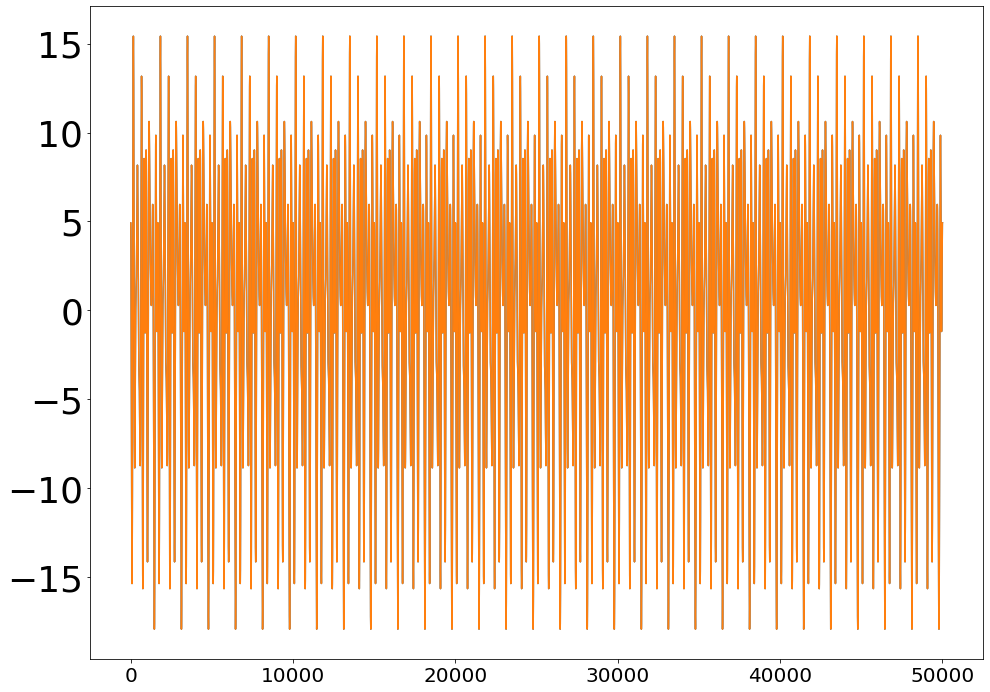

In [23]:
run_no =np.arange(0,no,1)
#np.random.shuffle(run_no)

for i in tqdm(range(2)):
    alpha_bkg_push = a_b_l_push[i]
    alpha_bkg_pull = a_b_l_pull[i]
    phases_bkg = t_b_l[i]
    
    z_sig_10,tps_s,as_s = mock_injection_signal(alpha_scale_in[i],lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF")
    if(np.mean(np.divide(1,alpha_bkg_push)>50)):
        z_bkg_push_10,_,_,_ = mock_injection_bkg(alpha_scale_bkg=alpha_scale_bkg_push,lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = phases_bkg)
        print("adding push signal")
    else: z_bkg_push_10=0
    if(np.mean(np.divide(1,alpha_bkg_pull)>50)):
        z_bkg_pull_10,_,_,_ = mock_injection_bkg(alpha_scale_bkg=alpha_scale_bkg_pull,lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = phases_bkg)
        print("adding pull signal")
    else: z_bkg_pull_10=0
       
    final_signal = z_sig_10 + z_bkg_pull_10  - z_bkg_push_10
    plt.plot(final_signal)
    
    file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction=direction_in[i],run_no=run_no[i],max_file=1000)    
    #metafile_creator(i)
    metafile_creator_bkg(i)

np.save(out_dir+"run_no.npy",run_no)
np.save(out_dir+"alpha_scale_in.npy",alpha_scale_in)
np.save(out_dir+"lambda_val_in.npy",lambda_val_in)
np.save(out_dir+"direction_in.npy",direction_in)
np.save(out_dir+"phase_shift_in.npy",phase_shift_in)
np.save(out_dir+"alpha_scale_bkg_push.npy",a_b_l_push)
np.save(out_dir+"alpha_scale_bkg_pull.npy",a_b_l_pull)



  0%|          | 0/2 [00:00<?, ?it/s]

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
adding pull signal


 50%|█████     | 1/2 [01:18<01:18, 78.77s/it]

Done
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
adding pull signal


100%|██████████| 2/2 [02:37<00:00, 78.91s/it]

Done


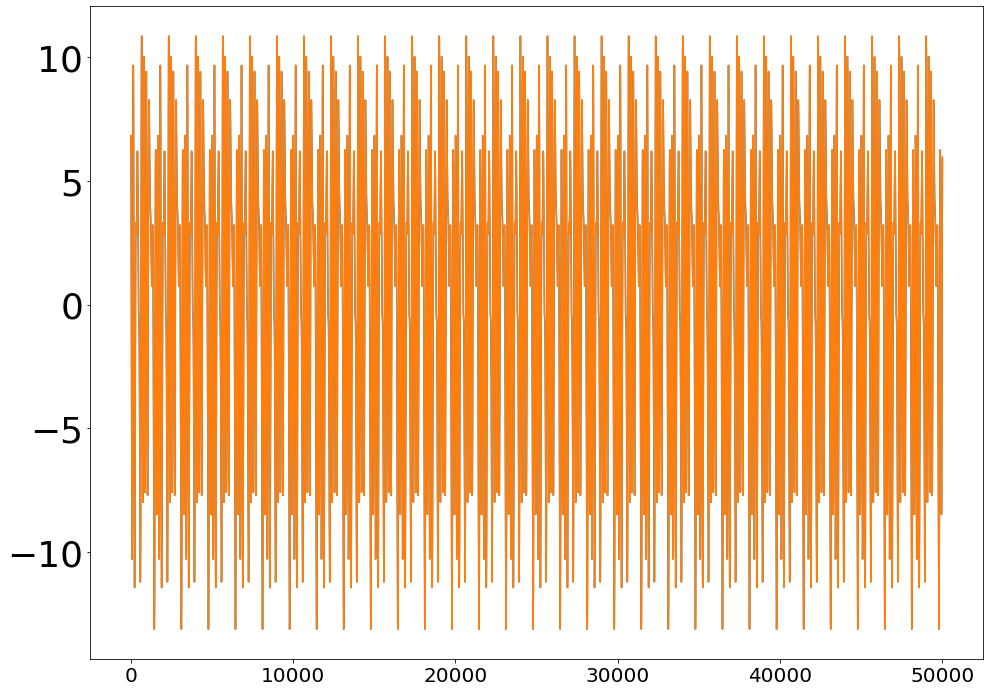

In [26]:
run_no =np.arange(0,no,1)
#np.random.shuffle(run_no)

for i in tqdm(range(2)):
    alpha_bkg_push = a_b_l_push[i]
    alpha_bkg_pull = a_b_l_pull[i]
    phases_bkg = t_b_l[i]
    
    z_sig_10,tps_s,as_s = mock_injection_signal(alpha_scale_in[i],lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF")
    if(np.mean(np.divide(1,alpha_bkg_push)>50)):
        z_bkg_push_10,_,_,_ = mock_injection_bkg(alpha_scale_bkg=alpha_scale_bkg_push,lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = phases_bkg)
        print("adding push signal")
    else: z_bkg_push_10=0
    if(np.mean(np.divide(1,alpha_bkg_pull)>50)):
        z_bkg_pull_10,_,_,_ = mock_injection_bkg(alpha_scale_bkg=alpha_scale_bkg_pull,lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = phases_bkg)
        print("adding pull signal")
    else: z_bkg_pull_10=0
       
    final_signal = z_sig_10 + z_bkg_pull_10  - z_bkg_push_10
    plt.plot(final_signal)
    
    file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction=direction_in[i],run_no=run_no[i],max_file=1000)    
    #metafile_creator(i)
    metafile_creator_bkg(i)

np.save(out_dir+"run_no.npy",run_no)
np.save(out_dir+"alpha_scale_in.npy",alpha_scale_in)
np.save(out_dir+"lambda_val_in.npy",lambda_val_in)
np.save(out_dir+"direction_in.npy",direction_in)
np.save(out_dir+"phase_shift_in.npy",phase_shift_in)
np.save(out_dir+"alpha_scale_bkg_push.npy",a_b_l_push)
np.save(out_dir+"alpha_scale_bkg_pull.npy",a_b_l_pull)

